<a href="https://colab.research.google.com/github/racuna2009/cv/blob/main/LSTM_NLSE_T0i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Verificar archivos en el directorio
# import os

# data_dir = '/content/drive/My Drive/Data_NN'
# files = os.listdir(data_dir)
# print(f"Archivos en {data_dir}: {files}")


In [ ]:
# %%
import os
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import psutil
import gc

In [ ]:
# %%
def data_generator(data_dir, batch_size=100):
    npz_files = glob.glob(os.path.join(data_dir, 'P_w_*.npz'))
    for i in range(0, len(npz_files), batch_size):
        spectra = []
        labels = []
        batch_files = npz_files[i:i+batch_size]
        for file in batch_files:
            match = re.search(r'P_w_(\d+(\.\d+)?)\.npz', file)
            if match:
                T0i = float(match.group(1))
                data = np.load(file)
                P_w_sampled = data['P_w_sampled']
                spectra.append(P_w_sampled)
                labels.append(T0i)
        print(f"Processed batch {i//batch_size + 1}/{(len(npz_files) + batch_size - 1)//batch_size}")
        yield np.array(spectra), np.array(labels)
        spectra.clear()
        labels.clear()
        gc.collect()

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory usage: {mem_info.rss / (1024 * 1024)} MB")

In [ ]:
# %%
# Load the data using the generator
data_dir = '/content/drive/My Drive/Data_NN'  # Cambia esta ruta a la correcta en tu Google Drive
generator = data_generator(data_dir, batch_size=100)

# Initialize lists to store data
spectra_list = []
labels_list = []

# Iterate through the generator to load data
for spectra, labels in generator:
    spectra_list.append(spectra)
    labels_list.append(labels)
    print_memory_usage()
    gc.collect()  # Free up memory

# Concatenate all batches
spectra = np.concatenate(spectra_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
print(f"Total files loaded: {len(labels)}")


Processed batch 1/1
Memory usage: 2150.9609375 MB
Total files loaded: 99


In [ ]:
# %%
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(spectra, labels, test_size=0.2, random_state=42)

# %%
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])


In [ ]:
# %%
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Use a small batch size to prevent memory overload
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[early_stopping])


Epoch 1/50
10/10 [==============================] - 9s 220ms/step - loss: 3045.4246 - mean_absolute_error: 55.1113 - val_loss: 3010.9844 - val_mean_absolute_error: 54.7846
Epoch 2/50
10/10 [==============================] - 1s 99ms/step - loss: 3043.7671 - mean_absolute_error: 55.0965 - val_loss: 3009.8230 - val_mean_absolute_error: 54.7740
Epoch 3/50
10/10 [==============================] - 1s 105ms/step - loss: 3042.6614 - mean_absolute_error: 55.0866 - val_loss: 3008.4111 - val_mean_absolute_error: 54.7612
Epoch 4/50
10/10 [==============================] - 2s 227ms/step - loss: 3040.5225 - mean_absolute_error: 55.0665 - val_loss: 3006.8364 - val_mean_absolute_error: 54.7468
Epoch 5/50
10/10 [==============================] - 3s 291ms/step - loss: 3040.1353 - mean_absolute_error: 55.0642 - val_loss: 3005.2825 - val_mean_absolute_error: 54.7326
Epoch 6/50
10/10 [==============================] - 2s 170ms/step - loss: 3037.3467 - mean_absolute_error: 55.0379 - val_loss: 3003.5947 - va

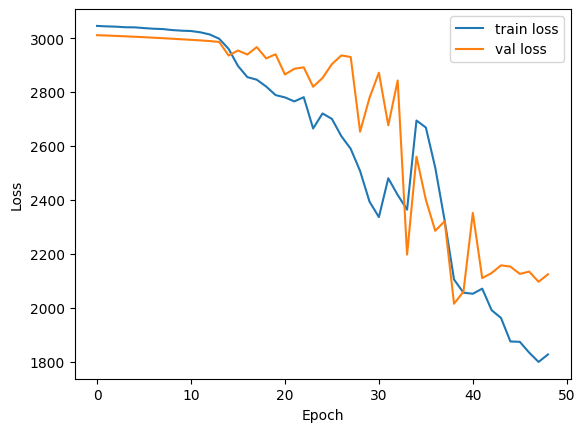

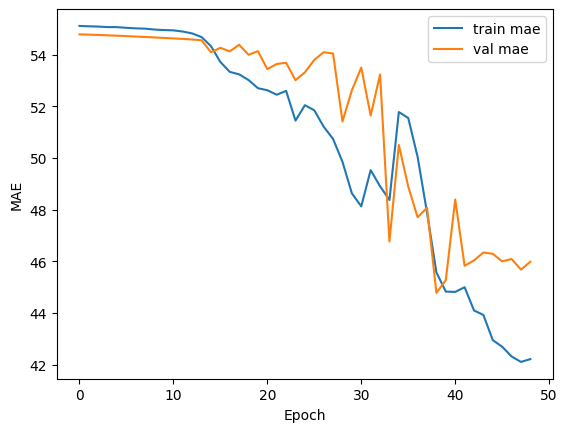

In [ ]:
# %%
# Plot the training history
output_dir = 'LSTM_results'
os.makedirs(output_dir, exist_ok=True)

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(output_dir, 'training_history_loss.png'))
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'], label='train mae')
plt.plot(history.history['val_mean_absolute_error'], label='val mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.savefig(os.path.join(output_dir, 'training_history_mae.png'))
plt.show()


1/1 [==============================] - 1s 820ms/step
R²: -208.28878859776626
MAE: 44.78048946380615


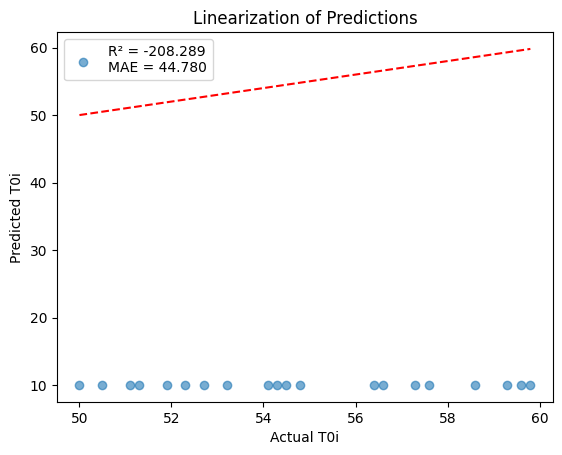

In [ ]:
# %%
# Make predictions
y_pred = model.predict(X_val)

# Calculate R^2 and MAE
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f'R²: {r2}')
print(f'MAE: {mae}')

# Plot linearization
plt.figure()
plt.scatter(y_val, y_pred, label=f'R² = {r2:.3f}\nMAE = {mae:.3f}', alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual T0i')
plt.ylabel('Predicted T0i')
plt.title('Linearization of Predictions')
plt.legend()
plt.savefig(os.path.join(output_dir, 'predictions.png'))
plt.show()